In [1]:
#Exam neural network
from ucimlrepo import fetch_ucirepo 
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

import seaborn as sns
import pandas as pd

steel_plates_faults = fetch_ucirepo(id=198) 

# data (as pandas dataframes) 
X = steel_plates_faults.data.features 
y = steel_plates_faults.data.targets

#y = steel_plates_faults.data.targets
y_single = steel_plates_faults.data.targets.idxmax(axis=1)
y_encoded = y_single.astype("category").cat.codes
class_names = list(y_single.astype("category").cat.categories)
#split training and test
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

y.value_counts()

Pastry  Z_Scratch  K_Scratch  Stains  Dirtiness  Bumps  Other_Faults
0       0          0          0       0          0      1               673
                                                 1      0               402
                   1          0       0          0      0               391
        1          0          0       0          0      0               190
1       0          0          0       0          0      0               158
0       0          0          1       0          0      0                72
                              0       1          0      0                55
Name: count, dtype: int64

In [2]:
## adjustments for the hyperparameters.
from tensorflow.keras.optimizers import Adam
#optimizer = "sgd"
optimizer = Adam(learning_rate=0.001)
layer = 500
epoch = 1000

In [3]:
#scaling of data for the neural network.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [4]:
#keras used to make the layers of the neural network model
tf.keras.backend.clear_session()
tf.random.set_seed(42)

tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[X_train.shape[1]]),
    tf.keras.layers.Dense(layer, activation="relu"),
    tf.keras.layers.Dense(layer, activation="relu"),
    tf.keras.layers.Dense(len(y_single.unique()), activation="softmax")
])
model.summary()

C:\Users\Adria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                 ┃ Output Shape         ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ dense (Dense)                │ (None, 500)          │      14,000 │
├──────────────────────────────┼──────────────────────┼─────────────┤
│ dense_1 (Dense)              │ (None, 500)          │     250,500 │
├──────────────────────────────┼──────────────────────┼─────────────┤
│ dense_2 (Dense)              │ (None, 7)            │       3,507 │
└──────────────────────────────┴──────────────────────┴─────────────┘

 Total params: 268,007 (1.02 MB)

 Trainable params: 268,007 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
#compiling model, using the adam optimizer and loss.
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [6]:
from sklearn.utils.class_weight import compute_class_weight

#using class weights which are inversly proportional to the appearance frequency.
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(zip(np.unique(y_train), class_weights))

In [7]:
#early stopping to achieve ideal epoch
#saving weights
model.save_weights("my_weights.weights.h5")
model.save("my_model.keras")
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_checkpoints.weights.h5", 
                                                   save_weights_only=True)
#early stopping based on the validation loss, with patience of 5
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,monitor='val_loss',
                                                     restore_best_weights=True)


In [8]:
#fitting of the model
history = model.fit(X_train, y_train, epochs=epoch, class_weight=class_weights, validation_split=0.2, callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/1000
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5383 - loss: 0.9982 - val_accuracy: 0.6463 - val_loss: 0.8590
Epoch 2/1000
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6737 - loss: 0.6187 - val_accuracy: 0.6945 - val_loss: 0.8118
Epoch 3/1000
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7228 - loss: 0.5172 - val_accuracy: 0.7235 - val_loss: 0.7798
Epoch 4/1000
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7558 - loss: 0.4520 - val_accuracy: 0.7363 - val_loss: 0.7615
Epoch 5/1000
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7647 - loss: 0.4075 - val_accuracy: 0.7363 - val_loss: 0.7549
Epoch 6/1000
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7792 - loss: 0.3702 - val_accuracy: 0.7428 - val_loss: 0.7515
Epoch 7/1000
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7977 - loss: 0.3371 - val_accuracy: 0.7460 - val_loss: 0.7438
Epoch 8/1000
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8090 - loss: 0.3085 - val_accuracy: 0

In [9]:
#evaluation #f1 bec its good for imbalance, macro is for multi class classification
from sklearn.metrics import f1_score
y_pred = model.predict(X_test).argmax(axis=1)

#saves the f1 score
macro_f1 = f1_score(y_test, y_pred, average="macro")
acc = model.evaluate(X_test, y_test)

#saving test results in a .txt file to monitor improvments for different hyperparameter choices
TestResult = "Epoch:" + str(epoch), "Layer:"+ str(layer), "Optimizer:" +str(optimizer),"Macro F1 Score:" + str(round(macro_f1,4)), "accuracy:" + str(round(acc[1],4)), "loss:" + str(round(acc[0],4))
TestResult = str(TestResult)
print(TestResult) 
with open('MultiClassLog.txt', 'a') as output:
    output.write(TestResult+"\n")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7661 - loss: 0.6846 
('Epoch:1000', 'Layer:500', 'Optimizer:<keras.src.optimizers.adam.Adam object at 0x000001F50060C050>', 'Macro F1 Score:0.7635', 'accuracy:0.7661', 'loss:0.6846')


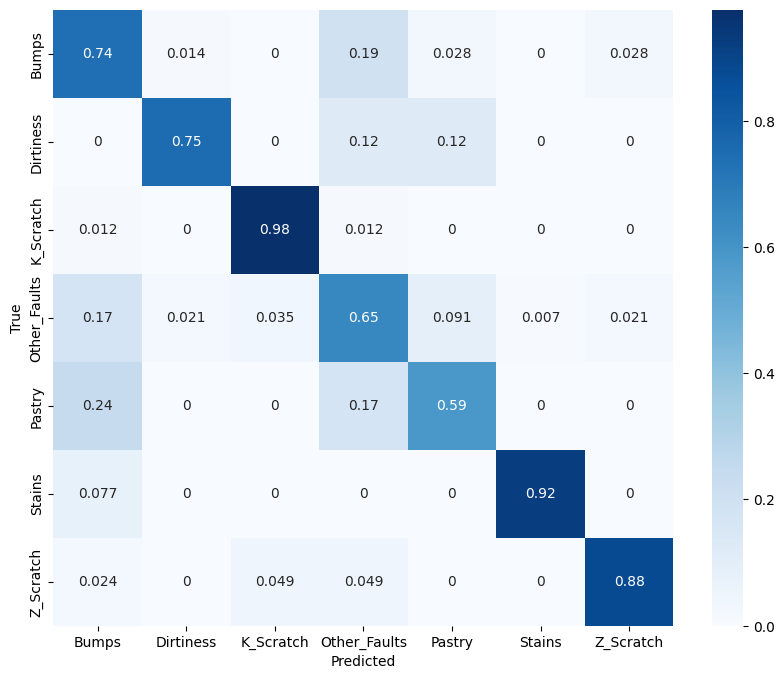

In [10]:

#normalized confusion matrix
cm = confusion_matrix(y_test, y_pred,normalize="true")

#plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")

#saving confusion matrix as image for evaluation of hyperparameters
#plt.savefig("ConfusionMatrixMultiClass/confusion_matrix"+str(epoch)+str(optimizer)+str(layer)+".png", dpi=300, bbox_inches='tight')
plt.show()